## Loan Approval Prediction
https://www.kaggle.com/competitions/playground-series-s4e10

#### Contents:
1. Introduction
2. Data Exploration
3. Data Processing
4. Machine Learning
5. Evaluation




#### 1. Introduction

Your Goal: The goal for this competition is to predict whether an applicant is approved for a loan.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

The Data:
The data set contains 23 columns consisting  binary, categorical and numerical values. The target value is called loan_status and is a binary value being either 1 or 0. The other columns are as followed:

Numerical:\
Id\
Person_age\
Person_income\
Person_emp_lenght\
Loan_amnt\
Loan_int_rate\
Loan_percent_income\
cb_person_cred_hist_length

Categorical:\
Person_home_ownership\
Loan_intent\
Loan_grade\
cb_person_default_on_file






In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score
# ROC is used for evaluation of model

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_output = pd.DataFrame()
df_output['id'] = df_test['id'].copy()

In [4]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


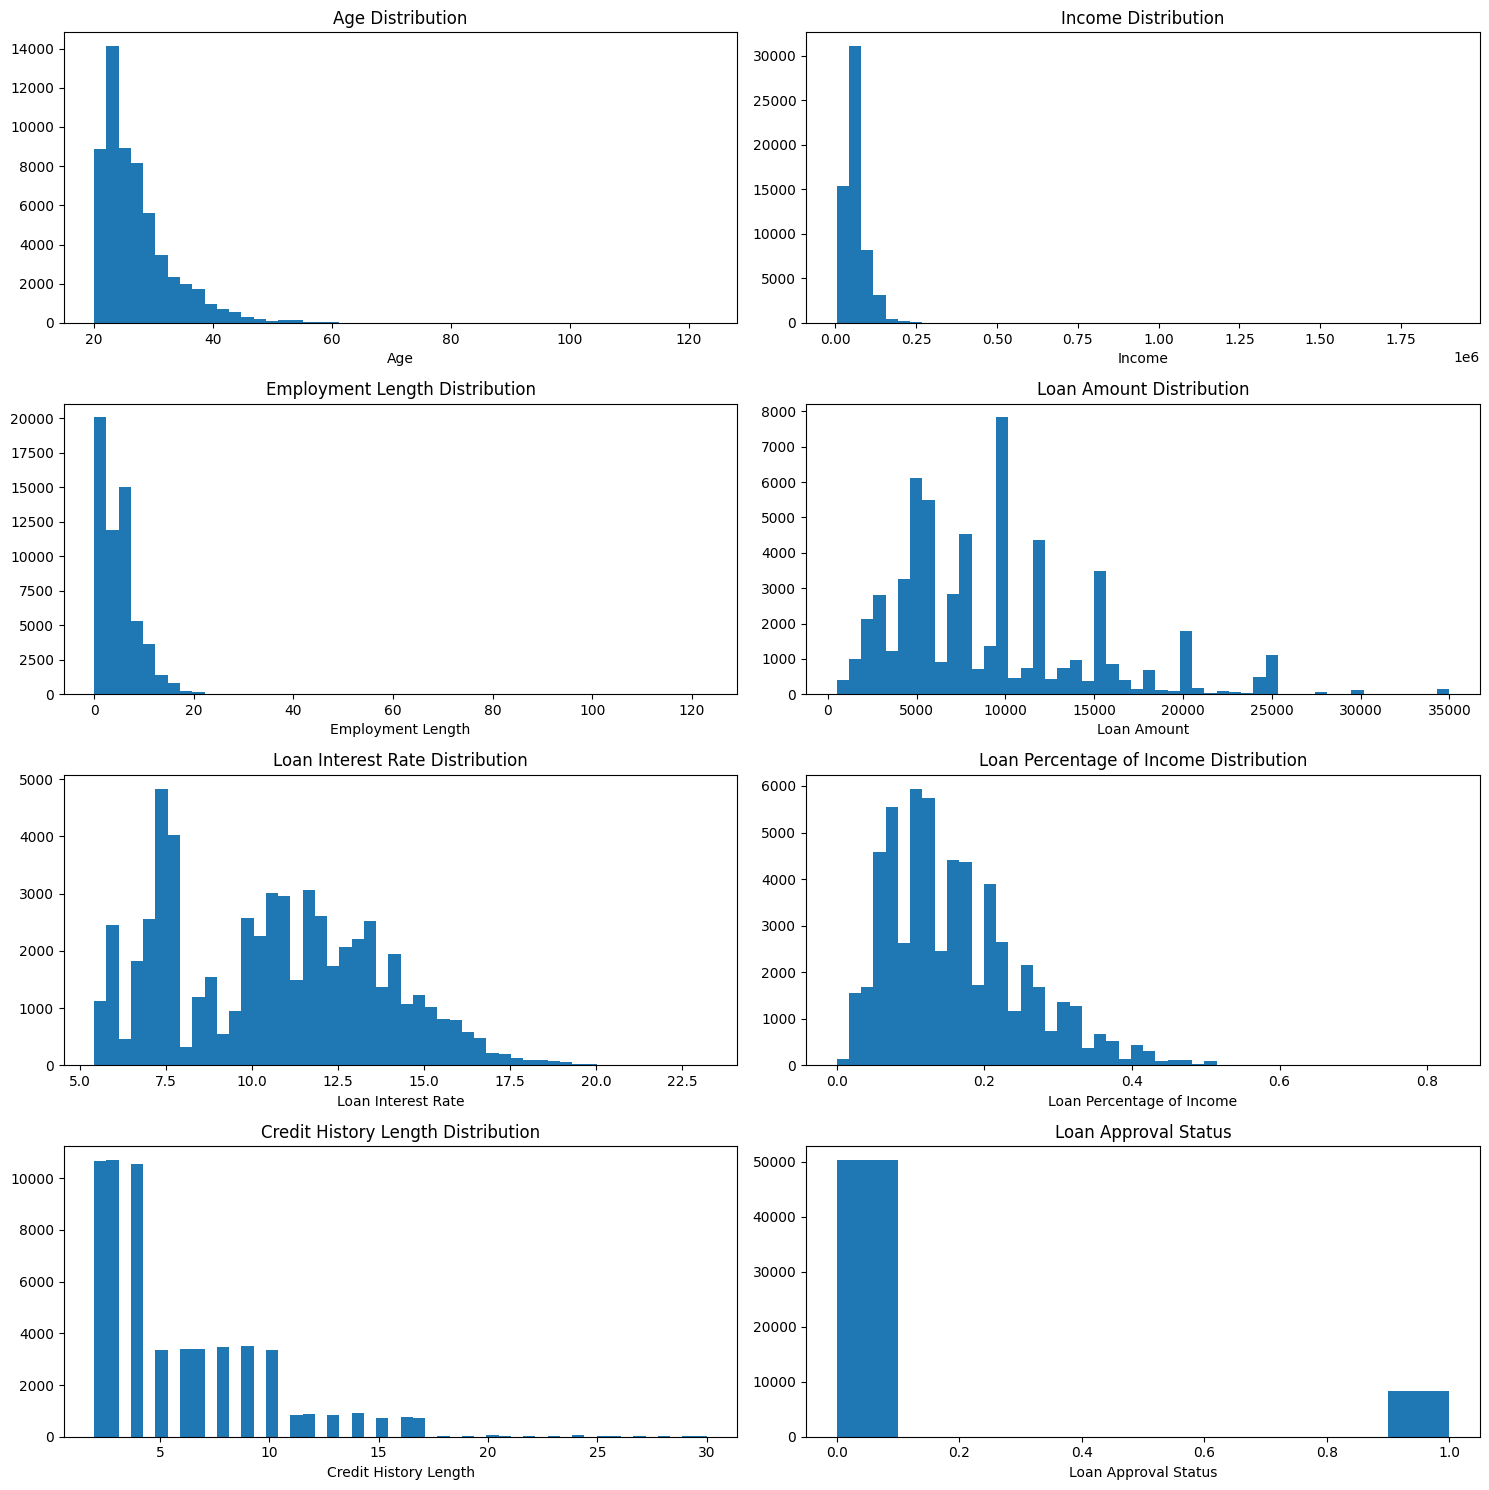

In [30]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
ax[0,0].hist(df_train['person_age'], bins=50)
ax[0,0].set(xlabel = 'Age')
ax[0,0].set_title('Age Distribution')
ax[0,1].hist(df_train['person_income'], bins=50)
ax[0,1].set(xlabel = 'Income')
ax[0,1].set_title('Income Distribution')
ax[1,0].hist(df_train['person_emp_length'], bins=50)
ax[1,0].set(xlabel = 'Employment Length')
ax[1,0].set_title('Employment Length Distribution')
ax[1,1].hist(df_train['loan_amnt'], bins=50)
ax[1,1].set(xlabel = 'Loan Amount')
ax[1,1].set_title('Loan Amount Distribution')
ax[2,0].hist(df_train['loan_int_rate'], bins=50)
ax[2,0].set(xlabel = 'Loan Interest Rate')
ax[2,0].set_title('Loan Interest Rate Distribution')
ax[2,1].hist(df_train['loan_percent_income'], bins=50)
ax[2,1].set(xlabel = 'Loan Percentage of Income')
ax[2,1].set_title('Loan Percentage of Income Distribution')
ax[3,0].hist(df_train['cb_person_cred_hist_length'], bins=50)
ax[3,0].set(xlabel = 'Credit History Length')
ax[3,0].set_title('Credit History Length Distribution')
ax[3,1].hist(df_train['loan_status'])
ax[3,1].set(xlabel = 'Loan Approval Status')
ax[3,1].set_title('Loan Approval Status')
fig.tight_layout()


In [85]:
def remove_outliers(df : pd.DataFrame, columns : list, significance: int):
    for column in columns:
        upperLimit = df[column].quantile(1-significance*.01)
        lowerLimit = df[column].quantile(significance*.01)
        df = df.loc[(df[column] > lowerLimit) & (df[column] < upperLimit)]
    return df

def normalize_data(df : pd.DataFrame, columns : list):
    for column in columns:
        df[column] = df[column] / df[column].abs().max() 
    return df

def create_dummies(df : pd.DataFrame, columns : list):
    for column in columns:
        df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], prefix=column)], axis=1)
    return df

In [86]:
columns_outliers = ['person_income', 'loan_amnt', 'person_age', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
columns_normalization = ['person_income', 'loan_amnt', 'person_age', 'person_emp_length', 'loan_percent_income', 'cb_person_cred_hist_length']
columns_dummies = ['person_home_ownership', 'loan_intent', 'loan_grade']

#df_train = remove_outliers(df_train, columns_outliers, 1)
df_train = normalize_data(df_train, columns_normalization)
df_train = create_dummies(df_train, columns_dummies)
df_train['cb_person_default_on_file'] = df_train['cb_person_default_on_file'].map(dict(Y=1, N=0))

df_test = normalize_data(df_test, columns_normalization)
df_test = create_dummies(df_test, columns_dummies)
df_test['cb_person_default_on_file'] = df_test['cb_person_default_on_file'].map(dict(Y=1, N=0))

In [87]:
df_train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [88]:
# Balance Dataset by oversampling
minority_class = df_train[df_train['loan_status'] == 1]
majority_class = df_train[df_train['loan_status'] == 0]


minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
df_train = pd.concat([majority_class, minority_upsampled])

In [89]:
df_train['loan_status'].value_counts()

loan_status
0    50295
1    50295
Name: count, dtype: int64

In [90]:
df_train.corr()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
id,1.000000,0.012765,0.003240,0.000373,0.001341,0.000044,-0.005371,-0.005972,0.010503,-0.013268,...,0.000046,-0.008751,0.004451,0.001588,-0.005988,0.002691,-0.001924,0.008912,-0.005005,0.010526
person_age,0.012765,1.000000,0.086611,0.112172,0.035820,0.003597,-0.031757,-0.005213,0.876588,-0.002763,...,0.020358,0.059432,-0.019513,-0.003239,0.000345,-0.012105,0.008534,0.006879,0.011650,0.007187
person_income,0.003240,0.086611,1.000000,0.189815,0.285420,-0.096463,-0.317030,-0.054004,0.069676,-0.279419,...,-0.054110,-0.003464,0.013517,0.081098,0.021532,-0.044186,-0.059478,-0.015010,-0.012647,-0.017978
person_emp_length,0.000373,0.112172,0.189815,1.000000,0.090401,-0.122199,-0.086742,-0.066140,0.090289,-0.143173,...,0.008074,-0.001075,-0.001002,0.100151,0.024048,-0.051440,-0.061226,-0.041439,-0.023711,-0.015948
loan_amnt,0.001341,0.035820,0.285420,0.090401,1.000000,0.078174,0.653018,-0.002784,0.032779,0.191239,...,-0.008506,-0.014782,0.005167,-0.093510,0.063664,-0.031145,0.022279,0.060691,0.033240,0.003999
loan_int_rate,0.000044,0.003597,-0.096463,-0.122199,0.078174,1.000000,0.106158,0.496419,0.000839,0.447614,...,0.041959,-0.036978,-0.029086,-0.786013,-0.132852,0.264093,0.557092,0.326718,0.163810,0.106424
loan_percent_income,-0.005371,-0.031757,-0.317030,-0.086742,0.653018,0.106158,1.000000,0.008743,-0.023370,0.446208,...,0.022134,-0.001064,0.004420,-0.126179,0.059625,0.013998,0.019667,0.050324,0.045910,0.023444
cb_person_default_on_file,-0.005972,-0.005213,-0.054004,-0.066140,-0.002784,0.496419,0.008743,1.000000,-0.003538,0.228133,...,0.006576,-0.014099,-0.014104,-0.309517,-0.350472,0.320360,0.348119,0.141186,0.071879,0.033058
cb_person_cred_hist_length,0.010503,0.876588,0.069676,0.090289,0.032779,0.000839,-0.023370,-0.003538,1.000000,-0.005566,...,0.010673,0.054669,-0.016240,-0.001628,0.000582,-0.005191,0.001024,0.007053,0.007574,0.001645
loan_status,-0.013268,-0.002763,-0.279419,-0.143173,0.191239,0.447614,0.446208,0.228133,-0.005566,1.000000,...,0.063239,-0.015786,-0.099716,-0.313305,-0.117088,-0.013637,0.394372,0.168095,0.063486,0.037321


In [91]:
df_train, df_validation = train_test_split(df_train, test_size=0.333, random_state=42)

In [92]:
clf = xgb.XGBClassifier(tree_method='hist',random_state=42)
clf.fit(df_train.loc[:, df_train.columns != 'loan_status'], df_train['loan_status'])
predictions = clf.predict(df_validation.loc[:, df_validation.columns != 'loan_status'])

In [93]:
roc_auc_score(df_validation['loan_status'],predictions)

0.9356409342407741

In [94]:
predictions_test = clf.predict(df_test)
df_output['loan_status'] = predictions_test
df_output = df_output.set_index('id')
df_output.to_csv('Predictions_v4.csv')
